<img src="images/ublogo.png"/>

### CSE610 - Bayesian Non-parametric Machine Learning

  - Lecture Notes
  - Instructor - Varun Chandola
  - Term - Fall 2020

### Objective
The objective of this notebook is to discuss Bayesian non-parametric dimensionality reduction methods. We will primarily focus on **Gaussian Process Latent Variable Models** or GPLVM.

<div class="alert alert-info">

**Note:** This material is from several papers published in this area, including the NeurIPS 2004 paper by Neil Lawrence - [Gaussian Process Latent Variable Models for Visualisation of High Dimensional Data](http://papers.nips.cc/paper/2540-gaussian-process-latent-variable-models-for-visualisation-of-high-dimensional-data.pdf).

</div>

### Dimensionality reduction

### Problem setting
Let the observed data be denoted by ${\bf y}$, such that ${\bf y} \in \mathbb{R}^D$, where $D$ is presumably a big number. We are interested in mapping the data to ${\bf x}$, such that ${\bf x} \in \mathbb{R}^d$, such that $d \ll D$. 

Of course, we want ${\bf x}$ to preserve some properties of ${\bf y}$. Usually the dimensionality reduction problem is stated in the context of a data set $Y$, containing $N$ data instances in $\mathbb{R}^D$ and we are interested in transforming $Y$ to $X$ containing the corresponding $N$ data instances in $\mathbb{R}^d$, such that certain properties of $Y$ or of instances in $Y$ are preserved.

### Probabilistic Principal Components Analysis (PPCA)

In the *probabilistic PCA* model, the observed data instance, ${\bf y}$ is considered as a random variable, which is connected to the latent data instance ${\bf x}$, via a linear transformation, i.e.,
$$
p({\bf y}\vert {\bf x},W,\sigma^2) = \mathcal{N}(W{\bf x},\sigma^2I)
$$
where $W$ is a $D\times d$ orthogonal matrix. The prior distribution on the latent vectors, ${\bf x}$ is assumed to be a Gaussian, i.e., $p({\bf x}) = \mathcal{N}(0,I)$.
The marginalized likelihood of an observed data instance, ${\bf y}$ is given as:
$$
p({\bf y}\vert W,\sigma^2) = \int p({\bf y}\vert {\bf x},W,\sigma^2)p({\bf x})d{\bf x}
$$
One can estimate $W$ (and $\sigma^2$) by maximizing the marginalized likelihood of the data set
$$
p(Y \vert W, \sigma^2) = \prod_{n=1}^N p({\bf y}_n\vert W, \sigma^2I)
$$
where $Y$ is a $(N \times D)$ input matrix. Once $W$ is estimated, one can use the Bayes rule to estimate the posterior probability distribution for the latent vector, ${\bf x}$, i.e., $p({\bf x}\vert {\bf y}, W, \sigma^2_n)$, which will also be a Gaussian (no surprises there!!), in which the mean expression consists of $W^\top{\bf y}$. If $\sigma^2 \rightarrow 0$, PPCA reduces to PCA.

> PPCA places a prior on and marginalized the latent space $X$ and optimizes for $W$.

### Dual PPCA
A similar approach as PPCA, however, with a key "switch". Prior is placed on $W$ and the optimization is done on $X$.

$$
p({\bf y}\vert X,\sigma^2) = \int p({\bf y}\vert {\bf x},W,\sigma^2)p(W)dW
$$
> Both will give the same solution, just in a different way.

The marginalized probability distribution above, i.e., $p({\bf y}\vert X,\sigma^2)$, will also be a Gaussian, which means that the likelihood of the dataset, i.e., $p(Y\vert X,\sigma^2)$ will also be a Gaussian (assuming all ${\bf y}$'s to be i.i.d.). Assuming a prior on each row of $W$ as $\mathcal{N}(0,\alpha^{-1}I)$, this likelihood will have the following form:
$$
p(Y\vert X,\sigma^2) = \frac{1}{(2\pi)^{\frac{ND}{2}}\vert K\vert^{\frac{D}{2}}}\exp\left(-\frac{1}{2}tr(K^{-1}YY^\top)\right)
$$
where $K = \alpha XX^\top + \sigma^{-2}I$
> I am obviously skipping a lot of steps here

The log-likelihood will be a function of $K$, and in turn of $X$, as:
$$
L = -\frac{ND}{2} \log{2\pi} - \frac{D}{2}\log{\vert K\vert} - \frac{1}{2}tr(K^{-1}YY^\top)
$$
One can calculate the partial derivative of $L$ with respect to $X$ and apply an optimization procedure to obtain $X$, which is the low dimensional representation of $Y$.

### Gaussian Process Latent Variable Models
GPLVM generalizes PPCA by replacing the linear dependency in (1) with a non-linear function, $f()$, i.e., ${\bf y} = f({\bf x})$. It can be thought of as a non-linear version of the dual PPCA method. Instead of imposing a prior on $W$, a GP prior is imposed on $f()$. 

The general idea is that we express the marginalized log-likelihood of the observed data, $Y$, as a function of the unobserved latent data, $X$, and then use gradient descent, or something similar, to estimate $X$ that maximizes the marginalized log-likelihood.
> Question: How many unknown parameters will there be in the optimization problem?


### GPLVM in GPy
We will work with a handwritten digits data set in which each digit is a 16x16 false-color image. Let us start with PCA.

In [128]:
import numpy as np
import mpld3
from sklearn.decomposition import pca
%run Utilities.ipynb
%matplotlib notebook

In [116]:
digits = np.load('digits.npy')
which = [0,3,6,7,8,9] # which digits to work on
digits = digits[which,:,:,:]
num_classes, num_samples, height, width = digits.shape 
labels = np.array([[str(l)]*num_samples for l in which])


In [121]:
Y = np.reshape(digits,(digits.shape[0]*digits.shape[1],256))

In [123]:
Y.shape

(330, 256)

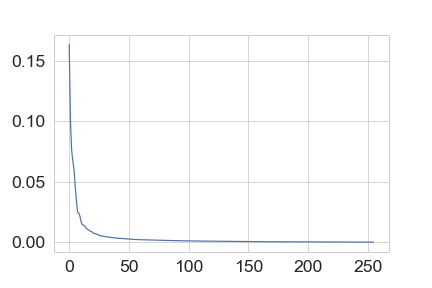

In [124]:
md = pca.PCA()
md.fit(Y)
plt.plot(md.explained_variance_ratio_)


In [125]:
md = pca.PCA(n_components=2)
st = time.time()
md.fit(Y)
en = time.time()
print('Finished in {:.2f} seconds.'.format(en-st))

Finished in 0.16 seconds.


<IPython.core.display.Javascript object>


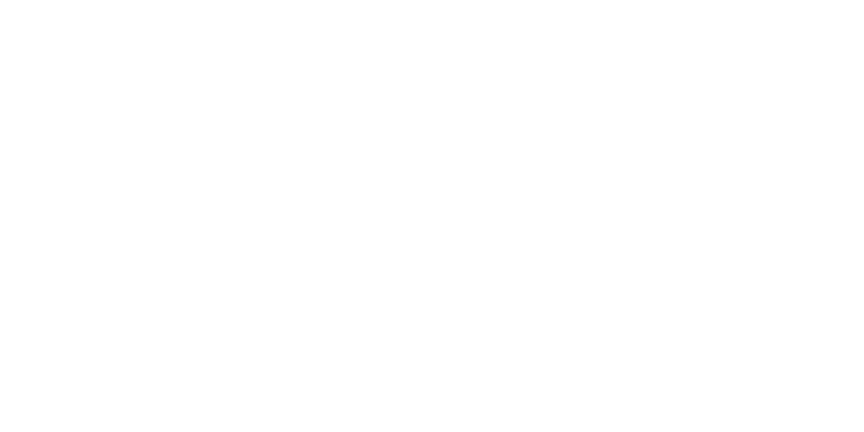

In [129]:
X = md.transform(Y)
fig = plt.figure(figsize=(12,6))
scatter = plt.scatter(X[:,0],X[:,1],c=labels)
labels1 = labels.flatten()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels1)
mpld3.plugins.connect(fig, tooltip)
mpld3.display(fig)


Now let us use GPLVM but with a linear kernel

In [130]:
Yn = Y-Y.mean()
input_dim = 2
kernel = GPy.kern.Linear(input_dim, ARD=True) # ARD kernel
kernel += GPy.kern.White(input_dim) + GPy.kern.Bias(input_dim)
md = GPy.models.GPLVM(Yn, input_dim=input_dim, kernel=kernel) 
st = time.time()
md.optimize(messages=1, max_f_eval=1000) # optimize for 1000 iterations 
en = time.time()
print('Finished in {:.2f} seconds'.format(en-st))

Finished in 5.19 seconds


<IPython.core.display.Javascript object>


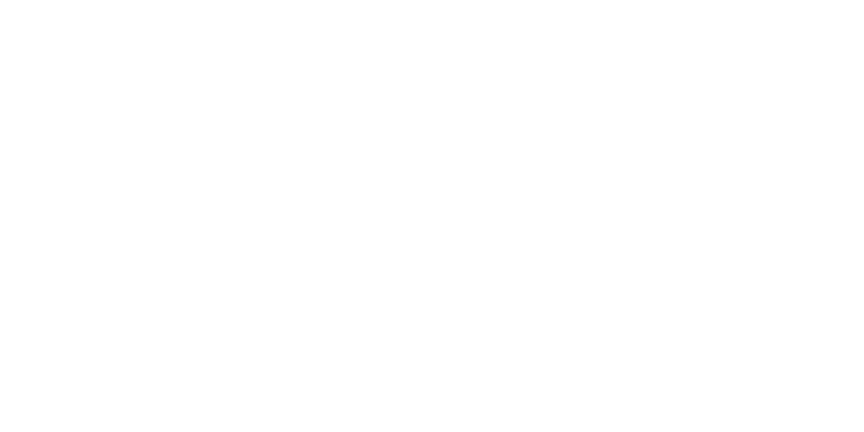

In [131]:
X = md.latent_mean
fig = plt.figure(figsize=(12,6))
scatter = plt.scatter(X[:,0],X[:,1],c=labels)
labels1 = labels.flatten()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels1)
mpld3.plugins.connect(fig, tooltip)
mpld3.display(fig)

The reduction using GPLVM with a linear kernel is not very different from the PCA reduction, as expected. Now let us employ a non-linear kernel.

In [132]:
Yn = Y-Y.mean()
input_dim = 2
md = GPy.models.GPLVM(Yn, input_dim=input_dim) # default kernel is RBF 
st = time.time()
md.optimize(messages=1, max_f_eval=1000) # optimize for 1000 iterations
en = time.time()
print('Finished in {:.2f} seconds'.format(en-st))

Finished in 30.65 seconds


<IPython.core.display.Javascript object>


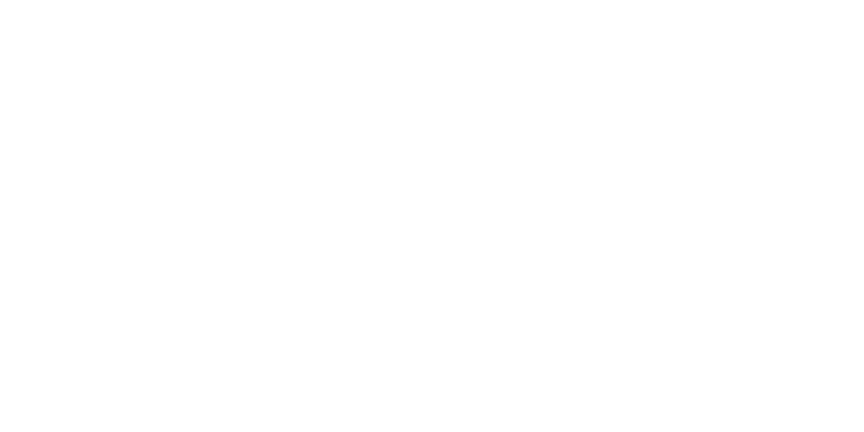

In [133]:
X = md.latent_mean
fig = plt.figure(figsize=(12,6))
scatter = plt.scatter(X[:,0],X[:,1],c=labels)
labels1 = labels.flatten()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels1)
mpld3.plugins.connect(fig, tooltip)
mpld3.display(fig)